In [2]:
import numpy as np
import pandas as pd

import os
from functools import reduce  

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from scipy.stats import pearsonr

In [3]:
#LOAD DATA
path = 'C:/Users/dilan/Documents/COMPSCI_590W/Final_Project/nhanes/'
ALQ_J = pd.read_csv(path+"/ALQ_J.csv")
BMX_J = pd.read_csv(path+"/BMX_J.csv")
DPQ_J = pd.read_csv(path+"/DPQ_J.csv")
DUQ_J = pd.read_csv(path+"/DUQ_J.csv")
OCQ_J = pd.read_csv(path+"/OCQ_J.csv")
PAQ_J = pd.read_csv(path+"/PAQ_J.csv")
SLQ_J = pd.read_csv(path+"/SLQ_J.csv")
SMQ_J = pd.read_csv(path+"/SMQ_J.csv")


In [32]:
#GET COLUMNS
ALQ_J = ALQ_J[['SEQN', 'ALQ130']]
BMX_J = BMX_J[['SEQN', 'BMXBMI']]
DPQ_J = DPQ_J[['SEQN', 'DPQ010', 'DPQ020', 'DPQ030', 'DPQ040', 'DPQ050', 'DPQ060', 'DPQ070', 'DPQ080', 'DPQ090']]
DUQ_J = DUQ_J[['SEQN', 'DUQ230']]
OCQ_J = OCQ_J[['SEQN', 'OCQ180']]
PAQ_J = PAQ_J[['SEQN', 'PAQ610']]
SLQ_J = SLQ_J[['SEQN', 'SLD012']]
SMQ_J = SMQ_J[['SEQN', 'SMD650']]
#JOIN
dfs = [ALQ_J, BMX_J, DPQ_J, DUQ_J, OCQ_J, PAQ_J, SLQ_J, SMQ_J]
data = reduce(lambda left, right: pd.merge(left, right, on=["SEQN"], how='outer'),dfs)


dpqdel = data[ (data['DPQ010'] == 7) & (data['DPQ010'] == 9)
                 & (data['DPQ020'] == 7) & (data['DPQ020'] == 9)
                 & (data['DPQ030'] == 7) & (data['DPQ030'] == 9)
                 & (data['DPQ040'] == 7) & (data['DPQ040'] == 9)
                 & (data['DPQ050'] == 7) & (data['DPQ050'] == 9)
                 & (data['DPQ060'] == 7) & (data['DPQ060'] == 9)
                 & (data['DPQ070'] == 7) & (data['DPQ070'] == 9)
                 & (data['DPQ080'] == 7) & (data['DPQ080'] == 9)
                 & (data['DPQ090'] == 7) & (data['DPQ090'] == 9)].index
data.drop(dpqdel, inplace=True)

#join depression columns into 1
data['PHQ-9'] = (data['DPQ010'].fillna(0)+data['DPQ020'].fillna(0)+
                  data['DPQ030'].fillna(0)+data['DPQ040'].fillna(0)+
                  data['DPQ050'].fillna(0)+data['DPQ060'].fillna(0)+
                  data['DPQ070'].fillna(0)+data['DPQ080'].fillna(0)+
                  data['DPQ090'].fillna(0))
#drop dpq columns
data = data.drop(['DPQ010','DPQ020','DPQ030','DPQ040','DPQ050','DPQ060','DPQ070','DPQ080','DPQ090'], axis = 1)

duqdel = data[ (data['DUQ230'] == 777) & (data['DUQ230'] == 999)].index
data.drop(duqdel, inplace=True)

#filter any rows containing nan
data = data.dropna()

#remove refusals and dont know
ocqdel = data[ (data['OCQ180'] == 77777) & (data['OCQ180'] == 77777)].index
data.drop(ocqdel, inplace=True)

alqdel = data[ (data['ALQ130'] == 777) & (data['ALQ130'] == 999)].index
data.drop(alqdel, inplace=True)

paqdel = data[ (data['PAQ610'] == 77) & (data['PAQ610'] == 99)].index
data.drop(paqdel, inplace=True)

smqdel = data[ (data['SMD650'] == 777) & (data['SMD650'] == 999)].index
data.drop(smqdel, inplace=True)

data
        


,SEQN,ALQ130,BMXBMI,DUQ230,OCQ180,PAQ610,SLD012,SMD650,PHQ-9
198,94012,12.0,25.2,7.0,32.0,4.0,6.0,20.0,1.0
511,94503,2.0,19.2,12.0,43.0,5.0,6.0,2.0,3.0
590,94638,1.0,32.9,30.0,50.0,6.0,7.0,5.0,1.0
713,94857,3.0,46.8,30.0,16.0,3.0,7.0,20.0,10.0
756,94926,3.0,21.8,30.0,44.0,7.0,7.0,35.0,3.0
...,...,...,...,...,...,...,...,...,...
5122,102283,4.0,31.3,20.0,60.0,5.0,6.0,1.0,19.0
5155,102340,4.0,21.6,28.0,70.0,6.0,8.5,20.0,7.0
5259,102495,12.0,25.3,3.0,16.0,5.0,3.5,10.0,3.0
5306,102589,5.0,38.8,30.0,40.0,5.0,7.0,10.0,8.0


In [31]:
features = data.iloc[:,1:7].to_numpy()
target = data.iloc[:,7].to_numpy() #PHQ-9

train_frac = 0.7
validate_frac = 0.2
test_frac = 1 - (train_frac + validate_frac)

np.random.seed(0)
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=test_frac)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=(validate_frac/(1-test_frac)))

scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [33]:
def rmse(y_true, y_pred):
    return np.sqrt(np.mean(np.square(y_true - y_pred)))

N_MODELS = 1000
alphas = np.logspace(-2, 6, N_MODELS)

RMSE_train = np.zeros((N_MODELS,))
RMSE_val = np.zeros((N_MODELS,))
coefs = np.zeros((N_MODELS, features.shape[1]))

for i, alpha in enumerate(alphas):
    model = Ridge(alpha=alpha).fit(X_train, y_train)
    coefs[i] = model.coef_
    RMSE_train[i] = rmse(y_train, model.predict(X_train))
    RMSE_val[i] = rmse(y_val, model.predict(X_val))

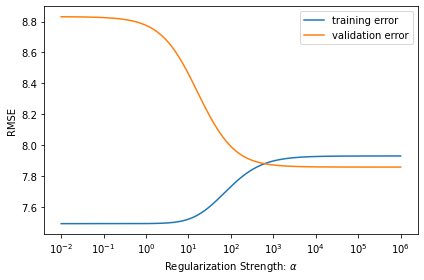

In [34]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
ax.plot(alphas, RMSE_train, label='training error')
ax.plot(alphas, RMSE_val, label='validation error')
ax.set_xticks(np.logspace(-2, 6, 9))
ax.set_xlabel('Regularization Strength: $\\alpha$')
ax.set_ylabel('RMSE')
ax.legend()
fig.tight_layout()

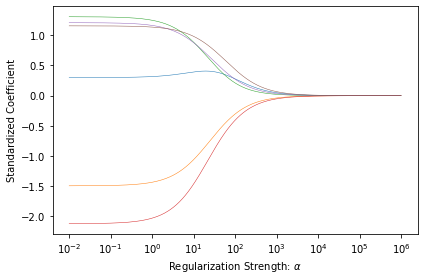

In [36]:
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(1, 1, 1)
ax.set_xscale('log')
ax.plot(alphas, coefs, linewidth=.5)
ax.set_xticks(np.logspace(-2, 6, 9))
ax.set_xlabel('Regularization Strength: $\\alpha$')
ax.set_ylabel('Standardized Coefficient')
fig.tight_layout()

In [39]:
model = Ridge(alpha=1e2).fit(X_train, y_train)
y_hat = model.predict(X_test)

r2 = r2_score(y_test, y_hat)
rmse = np.sqrt(np.mean(np.square(y_test - y_hat)))  
nrmse = rmse / np.ptp(y_test)

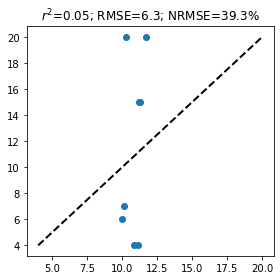

In [40]:
fig = plt.figure(figsize=(4, 4))
ax = fig.add_subplot(1, 1, 1)
ax.scatter(y_hat, y_test)
min_, max_ = min(y_hat.min(), y_test.min()), max(y_hat.max(), y_test.max())
x = np.linspace(min_, max_, 100)
ax.plot(x, x, linestyle='--', color='k', linewidth=2)
ax.set_title('$r^2$={:.2f}; RMSE={:.1f}; NRMSE={:.1f}%'.format(r2, rmse, nrmse * 100))
fig.tight_layout()